In [1]:
# author Alex J. Yang
import numpy as np
import pandas as pd
import itertools
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels

f = pd.read_csv(r'Allpaper.csv.zip')
fNobel = pd.read_csv(r'712 Nobelpapers.zip')
f['NobelField'] = f['PaperID'].map(fNobel.set_index('paperid')['Field'])
f['NobelField'].fillna(0 ,inplace=True)

def yearGroup(x):
    if x<1920:
        return '1900-1919'
    elif x<1940:
        return '1920-1939'
    elif x<1960:
        return '1940-1959'
    elif x<1980:
        return '1960-1979'
    else:
        return '1980-1999'
    
def delayGroup(x):
    if x<2:
        return x
    elif x<10:
        return '2-9'
    elif x<20:
        return '10-19'
    elif x<50:
        return '20-49'
    else:
        return '>50'
f['yearGroup'] = f['Year'].apply(yearGroup)
f['delayGroup'] = f['SB_T'].apply(delayGroup)

f['yearG'] = f['yearGroup'].map(dict(zip(f['yearGroup'].unique() , range(5))))

f1 = f[(f['type_Concave'] == 0)&(f['type_Immediacy'] == 0)].copy()
f2 = f[f['type_Concave'] == 1].copy()
f3 = f[f['type_Immediacy'] == 1].copy()

def convert_column_to_percentile(f, column_name):
    ranks = f[column_name].rank()
    percentiles = (ranks - 1) / (len(f) - 1) * 100
    f[column_name + '_percentile'] = percentiles
convert_column_to_percentile(f1, 'SB_B')

def BpGroup(x):
    if x<5:
        return 5
    elif x<50:
        return 50
    elif x<95:
        return 95
    else:
        return 100
f1['SB_B_p'] = f1['SB_B_percentile'].apply(BpGroup)

f1['SB_0_5']    = f1['SB_B_p'].apply(lambda x:1 if x==5 else 0)
f1['SB_5_50']   = f1['SB_B_p'].apply(lambda x:1 if x==50 else 0)
f1['SB_50_95']  = f1['SB_B_p'].apply(lambda x:1 if x==95 else 0)
f1['SB_95_100'] = f1['SB_B_p'].apply(lambda x:1 if x==100 else 0)

f['SB_0_5']    = f['PaperID'].map(f1.set_index('PaperID')['SB_0_5']   )
f['SB_5_50']   = f['PaperID'].map(f1.set_index('PaperID')['SB_5_50']  )
f['SB_50_95']  = f['PaperID'].map(f1.set_index('PaperID')['SB_50_95'] )
f['SB_95_100'] = f['PaperID'].map(f1.set_index('PaperID')['SB_95_100'])

f['SB_0_5']   .fillna(0,inplace = True)
f['SB_5_50']  .fillna(0,inplace = True)
f['SB_50_95'] .fillna(0,inplace = True)
f['SB_95_100'].fillna(0,inplace = True)

f['logCitation'] = np.log(f['Citation_Count']+1)
f['logPatent'] = np.log(f['Patent_Count']+1)
f['logReference'] = np.log(f['Reference_Count']+1)
f['logTeam'] = np.log(f['Team_Size']+1)
f['logInstitution'] = np.log(f['Institution_Count']+1)

In [2]:
f.columns

Index(['PaperID', 'Year', 'JournalID', 'SB_B', 'SB_T', 'type_Immediacy',
       'type_Concave', 'Citation_Count', 'C10', 'Reference_Count', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'Atyp_10pct_Z',
       'Atyp_Median_Z', 'Patent_Count', 'Newsfeed_Count', 'Tweet_Count',
       'FieldID', 'Fieldname', 'Hit_1pct', 'Hit_5pct', 'Hit_10pct', 'C_f',
       'NobelField', 'yearGroup', 'delayGroup', 'yearG', 'SB_0_5', 'SB_5_50',
       'SB_50_95', 'SB_95_100', 'logCitation', 'logPatent', 'logReference',
       'logTeam', 'logInstitution'],
      dtype='object')

In [3]:
colorlst = sns.color_palette(None,19)

Fieldlst = ['Art', 'Biology', 'Business', 'Chemistry', 'Computer science',
       'Economics', 'Engineering', 'Environmental science', 'Geography',
       'Geology', 'History', 'Materials science', 'Mathematics', 'Medicine',
       'Philosophy', 'Physics', 'Political science', 'Psychology',
       'Sociology']

In [37]:
def get_reg_c(f,colum,Field,regt):
    fF = f[f['Fieldname']==Field].copy()
    if regt=='ols':
        formula = '{} ~  SB_95_100 + SB_50_95 + SB_5_50 + SB_0_5 + type_Concave  + logReference + logTeam + C(year)'.format(colum)
    else:
        formula = 'Hit_1pct ~  SB_95_100 + SB_50_95 + SB_5_50 + SB_0_5 + type_Concave  + logReference + logTeam + C(year)'
    model = sm.formula.ols(formula=formula, data=fF).fit()
    coef = pd.DataFrame(model.params).loc['SB_95_100'].values[0]
    stde = pd.DataFrame(model.bse).loc['SB_95_100'].values[0]
    return [coef,stde]

In [38]:
colum = 'logCitation'
coeflst1 = []
stdelst1 = []
for F in Fieldlst:
    coef,stde = get_reg_c(f,colum,F,'ols')
    coeflst1.append(coef)
    stdelst1.append(stde)
coeflst1 = np.array(coeflst1)
stdelst1 = np.array(stdelst1)
stdelst1 = stdelst1*1.96

In [39]:
colum = 'logPatent'
coeflst2 = []
stdelst2 = []
for F in Fieldlst:
    coef,stde = get_reg_c(f,colum,F,'ols')
    coeflst2.append(coef)
    stdelst2.append(stde)
coeflst2 = np.array(coeflst2)
stdelst2 = np.array(stdelst2)
stdelst2 = stdelst2*1.96

In [40]:
fD = f.dropna(subset = 'Disruption').copy()

In [41]:
colum = 'Disruption'
coeflst3 = []
stdelst3 = []
for F in Fieldlst:
    coef,stde = get_reg_c(fD,colum,F,'ols')
    coeflst3.append(coef)
    stdelst3.append(stde)
coeflst3 = np.array(coeflst3)
stdelst3 = np.array(stdelst3)
stdelst3 = stdelst3*1.96

In [42]:
fN = f.dropna(subset = 'Atyp_Median_Z').copy()
fN['nAtyp_Median_Z'] = -fN['Atyp_Median_Z']
convert_column_to_percentile(fN, 'nAtyp_Median_Z')

In [43]:
colum = 'nAtyp_Median_Z_percentile'
coeflst4 = []
stdelst4 = []
for F in Fieldlst:
    coef,stde = get_reg_c(fN,colum,F,'ols')
    coeflst4.append(coef)
    stdelst4.append(stde)
coeflst4 = np.array(coeflst4)
stdelst4 = np.array(stdelst4)
stdelst4 = stdelst4*1.96

In [44]:
colum = 'Hit_1pct'
coeflst5 = []
stdelst5 = []
for F in Fieldlst:
    coef,stde = get_reg_c(f,colum,F,'logit')
    coeflst5.append(coef)
    stdelst5.append(stde)
coeflst5 = np.array(coeflst5)
stdelst5 = np.array(stdelst5)
stdelst5 = stdelst5*1.96

In [45]:
coeflsts = [coeflst1,coeflst2,coeflst3,coeflst4,coeflst5]

In [46]:
stdelsts = [stdelst1,stdelst2,stdelst3,stdelst4,stdelst5]

In [47]:
def drawCICom(coeflst , stdelst , ax , xtick , xlabel):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    for _ in range(len(Fieldlst)):
        ax.plot(coeflst[_], _, marker='o' ,color = '#2E4053',alpha=.7, markersize = 20 )
        ax.errorbar(coeflst[_] , _ , xerr = stdelst[_] ,ecolor='#273746', elinewidth=3 , capsize= 10 )
    # plt.xlim(0,1.5)
    plt.xticks(xtick, fontsize=20,)
    plt.axvline(x = 0 , c = '#A93226',alpha=.7, linestyle = '--', linewidth = 2)
    plt.xlabel(xlabel,fontsize = 25)
    plt.ylabel('',fontsize = 0)

In [48]:
xticklst = [[-1.2,0,1.2] , [-0.5,0,0.5] , [-0.2,0,0.2] , [-30,0,30] , [-0.8,0,0.8]]
xlabellst = ['ln(Citation)\nOLS' ,'ln(#Patent)\nOLS' , 'Disruption\nOLS' , 'Novelty\nOLS' , 'Hit\nLogit']

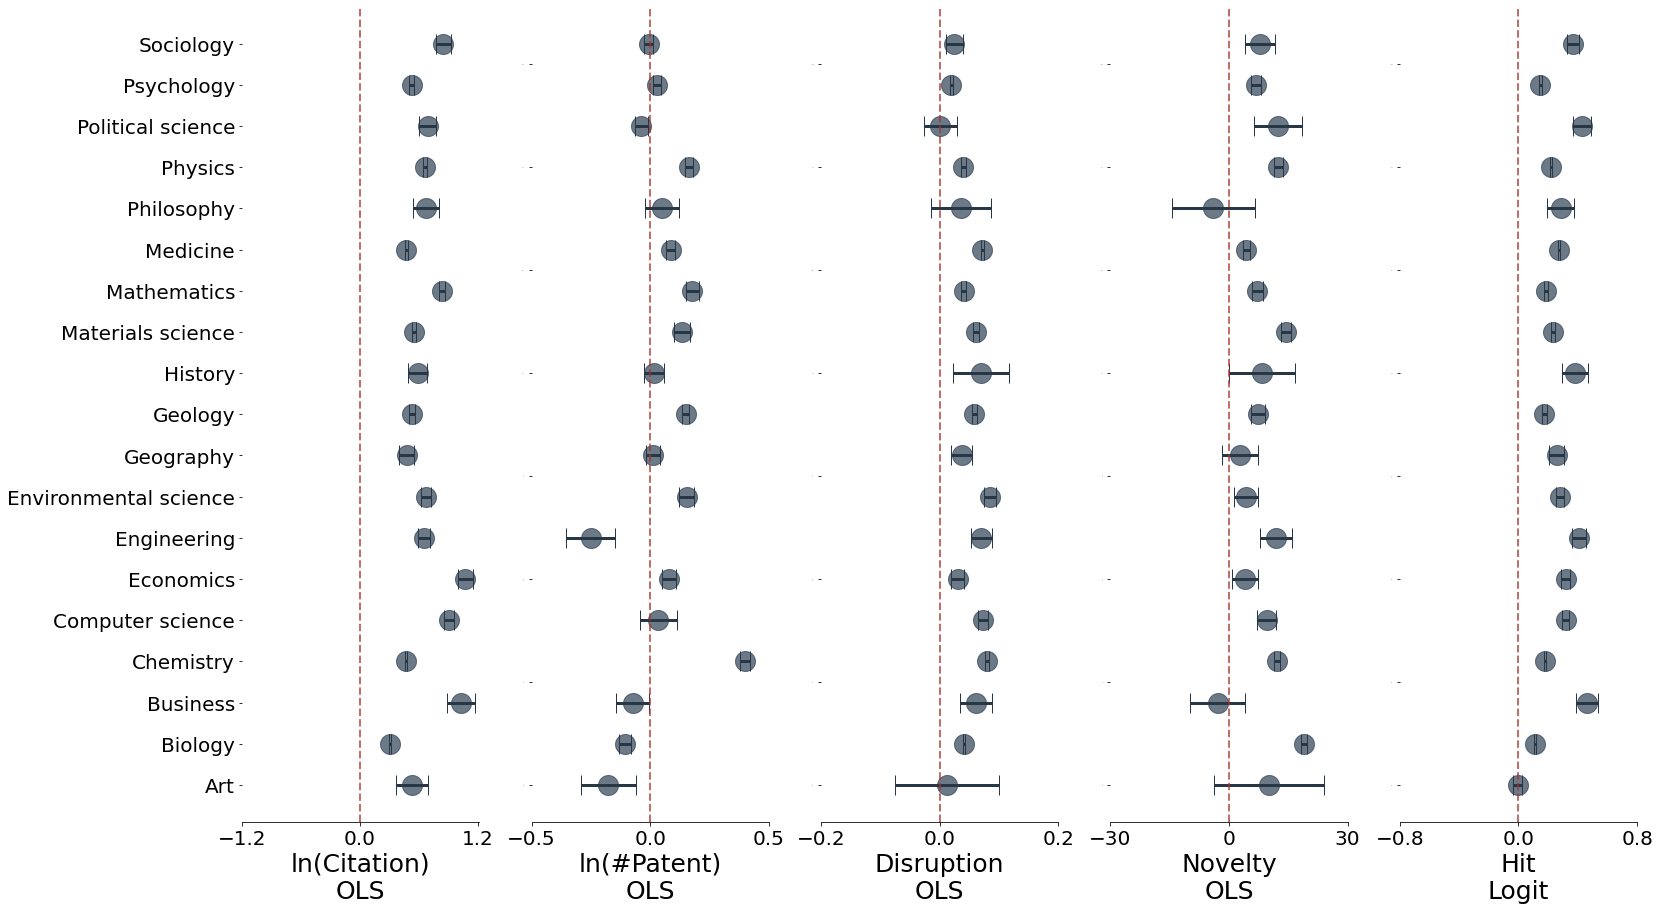

In [49]:
plt.subplots(1,5,figsize=(25,15))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0)
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    drawCICom(coeflsts[i] , stdelsts[i], ax , xticklst[i] , xlabellst[i])
    if i ==0:
        plt.yticks(range(len(Fieldlst)),Fieldlst,fontsize=20,)
    else:
        plt.yticks(fontsize=0,)